<a href="https://colab.research.google.com/github/PavelRawel/PavelRawel/blob/main/A_B_%D1%82%D0%B5%D1%81%D1%82_%D1%87%D0%B5%D0%BA%D0%B0%D1%83%D1%82%D0%B0_%D0%B4%D0%BB%D1%8F_Fundraise_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A/B тест чекаута для Fundraise Up**

Чекаут - один из ключевых составляющих продукта Fundraise Up. Чекаут - форма, которую видит пользователь (донор), когда собирается сделать пожертвование. Первый экран чекаута - экран с выбором размера пожертвования. Пользователь может выбрать размер пожертвования из подсказок на экране, либо ввести сумму самостоятельно. Кроме того, пользователь может сделать разовое пожертвования (вкладка “Give once”), либо сделать регулярное пожертвование (вкладка “Monthly”).						
Был проведен АБ-тест, в котором было протестировано одно изменение: на вкладке “Give once” убрано предзаполнение поля ввода суммы. До этого поле было предзаполнено значением одной из подсказок. 


In [ ]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("darkgrid")


## **1. Загрузка и обработка данных**

In [ ]:
df = pd.read_csv('FRU_analytics_test_task1.csv') #загружаем датасет
df.head()


,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test


In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58770 entries, 0 to 58769
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClientID      58770 non-null  int64  
 1   EventTime     58770 non-null  object 
 2   EventType     58770 non-null  object 
 3   DonationType  5364 non-null   object 
 4   AmountInUSD   5364 non-null   float64
 5   tag           53406 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.7+ MB


### EventTime в нашем датасете имеет формат object. Переведем в формат даты. Также добавим столбец Day.

In [ ]:
df['EventTime'] = pd.to_datetime(df['EventTime']) #меняем формат
df["day"] = df["EventTime"].dt.to_period("D") #добавляем day
df.head()

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag,day
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control,2022-07-20
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test,2022-07-20
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control,2022-07-20
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test,2022-07-20
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test,2022-07-20


### Из-за технических особенностей трекинговой системы у нас нет тега у тех юзеров, которые сделали донат. Исправим это. 

In [ ]:
df_notag = df[['ClientID','EventTime','EventType','DonationType','AmountInUSD', 'day' ]] #создаем новый датасет, который будет без тега

In [ ]:
df_notag 

,ClientID,EventTime,EventType,DonationType,AmountInUSD,day
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,2022-07-20
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,2022-07-20
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,2022-07-20
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,2022-07-20
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,2022-07-20
...,...,...,...,...,...,...
58765,244210529,2022-07-27 00:00:12,charge,one-time,62.0,2022-07-27
58766,920234036,2022-07-27 00:02:47,charge,one-time,110.0,2022-07-27
58767,450325260,2022-07-27 00:03:55,charge,one-time,32.0,2022-07-27
58768,450325260,2022-07-27 00:04:09,checkoutView,NaN,NaN,2022-07-27


In [ ]:
df_spisok_tag = df.query("tag in ('control', 'test')")[['ClientID','tag']] #создаем датасет, где будут ClientID и tag
df_spisok_tag 

,ClientID,tag
0,885410877,control
1,859319263,test
2,480984859,control
3,204664871,test
4,859319263,test
...,...,...
58760,920234036,control
58761,478785484,control
58762,592079509,control
58763,450325260,control


In [ ]:
#джойним новые датасеты и получаем исправленный датасет с проставленными тегами
df_ab = df_notag.merge(df_spisok_tag, on='ClientID', how='left').drop_duplicates(subset=['ClientID', 'EventTime']) 
df_ab 

,ClientID,EventTime,EventType,DonationType,AmountInUSD,day,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,2022-07-20,control
2,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,2022-07-20,test
4,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,2022-07-20,control
5,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,2022-07-20,test
7,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,2022-07-20,test
...,...,...,...,...,...,...,...
84007,244210529,2022-07-27 00:00:12,charge,one-time,62.0,2022-07-27,control
84008,920234036,2022-07-27 00:02:47,charge,one-time,110.0,2022-07-27,control
84009,450325260,2022-07-27 00:03:55,charge,one-time,32.0,2022-07-27,control
84011,450325260,2022-07-27 00:04:09,checkoutView,NaN,NaN,2022-07-27,control


In [ ]:
df_ab.to_csv(r' my_data.csv', index= False ) #сохраним датасет для будущего использования

## **2. Анализ данных**

In [ ]:
df_users = df_ab.groupby(['ClientID', 'tag', 'EventType','day' ], as_index=False)['AmountInUSD'].sum().sort_values('AmountInUSD',  ascending=False) #датасет с группировкой по юзерам 
df_users.head(20) #топ-20 донатов. Максимальный донат - 10000 usd

,ClientID,tag,EventType,day,AmountInUSD
4512,184432844,test,charge,2022-07-20,10000.0
38686,835670280,test,charge,2022-07-23,5000.0
37435,811492605,test,charge,2022-07-25,5000.0
12335,331680263,control,charge,2022-07-26,1000.0
15538,391875396,test,charge,2022-07-22,1000.0
22124,516697127,control,charge,2022-07-24,1000.0
25635,582559932,test,charge,2022-07-20,508.0
3076,157639237,control,charge,2022-07-22,500.0
43115,919080090,test,charge,2022-07-23,500.0
44530,945985153,control,charge,2022-07-23,500.0


In [ ]:
df_users_new = df_users = df_ab.groupby(['ClientID', 'tag', 'EventType', 'DonationType','day' ], as_index=False)['AmountInUSD'].sum().query("EventType=='charge'") 
#датасет с группировкой по юзерам, которые сделали донат

In [ ]:
df_users_new.AmountInUSD.describe() 
#немного статистики 

count     5115.000000
mean        82.149365
std        181.176024
min         10.000000
25%         20.000000
50%         61.000000
75%        114.000000
max      10000.000000
Name: AmountInUSD, dtype: float64

# **3. Анализируем продуктовые метрики**

## 3.1 Value - общая сумма донатов

In [ ]:
#переменные
amount = 'AmountInUSD' #переменная AmountInUSD

In [ ]:
df_value = df_users.groupby('tag', as_index=False)['AmountInUSD'].sum()

print ('Value для контрольной группы =', round(df_value.iloc[0][amount],3),'USD')
print ('Value для тестовой группы =', round(df_value.iloc[1][amount],3),'USD')
df_value

Value для контрольной группы = 203023.0 USD
Value для тестовой группы = 217171.0 USD


,tag,AmountInUSD
0,control,203023.0
1,test,217171.0


In [ ]:
df_value_donation = df_ab.groupby(['DonationType', 'tag'], as_index=False)['AmountInUSD'].sum() #Value в разбивке по типу доната
df_value_donation

,DonationType,tag,AmountInUSD
0,one-time,control,199062.0
1,one-time,test,213239.0
2,recurring,control,3961.0
3,recurring,test,3932.0


<AxesSubplot:xlabel='DonationType', ylabel='AmountInUSD'>

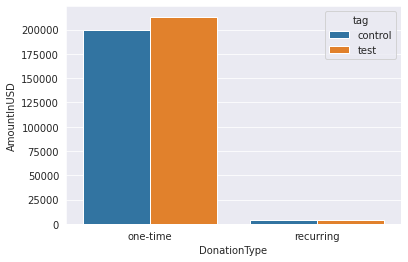

In [ ]:
sns.barplot(data=df_value_donation, x="DonationType", y="AmountInUSD",  hue="tag" ) #график Value в разбивке по типу доната

## 3.2 ARPU (average revenue per user) - метрика, которая показывает, сколько донатов в среднем приходится на одного пользователя за определенный промежуток времени.

In [ ]:
arpu = df_users.groupby(['tag'], as_index=False)['AmountInUSD'].mean()
print ('ARPU для контрольной группы =', round(arpu.iloc[0][amount],3),'USD')
print ('ARPU для тестовой группы =', round(arpu.iloc[1][amount],3),'USD')
arpu

ARPU для контрольной группы (единоразовый платеж)= 8.597 USD
ARPU для тестовой группы (единоразовый платеж)= 9.138 USD


,tag,AmountInUSD
0,control,8.597205
1,test,9.137502


## 3.3 ARPPU (Average Revenue Per Paying User) - метрика, которая показывает, сколько донатов в среднем приходится на **платящего** пользователя за определенный промежуток времени.

In [ ]:
arppu = df_users_new.groupby(['DonationType','tag'], as_index=False)['AmountInUSD'].mean()

print ('ARPPU для контрольной группы (единоразовый платеж)=', round(arppu.iloc[0][amount],3),'USD')
print ('ARPPU для тестовой группы (единоразовый платеж)=', round(arppu.iloc[1][amount],3),'USD')
print ('ARPPU для контрольной группы (ежемесячный платеж)=', round(arppu.iloc[2][amount],3),'USD')
print ('ARPPU для тестовой группы (ежемесячный платеж)=', round(arppu.iloc[3][amount],3),'USD')
arppu

ARPPU для контрольной группы (единоразовый платеж)= 84.492 USD
ARPPU для тестовой группы (единоразовый платеж)= 82.523 USD
ARPPU для контрольной группы (ежемесячный платеж)= 38.087 USD
ARPPU для тестовой группы (ежемесячный платеж)= 55.38 USD


,DonationType,tag,AmountInUSD
0,one-time,control,84.491511
1,one-time,test,82.522833
2,recurring,control,38.086538
3,recurring,test,55.380282


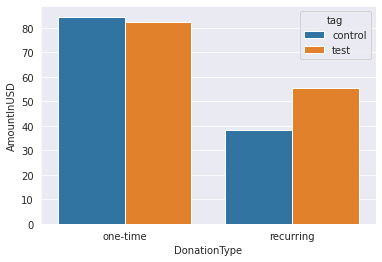

In [ ]:
sns.barplot(data=arppu, x="DonationType", y="AmountInUSD",  hue="tag" )

## 3.4 AOV - Cредний чек

In [ ]:
aov = df_ab.groupby(['DonationType', 'tag'], as_index=False)['AmountInUSD'].mean()
print ('AOV для контрольной группы (единоразовый платеж) =', round(aov.iloc[0]['AmountInUSD'],3),'USD')
print ('AOV для тестовой группы (единоразовый платеж) =', round(aov.iloc[1]['AmountInUSD'],3),'USD')
print ('AOV для контрольной группы (ежемесячный платеж)=', round(aov.iloc[2][amount],3),'USD')
print ('AOV для тестовой группы (ежемесячный платеж)=', round(aov.iloc[3][amount],3),'USD')
aov

AOV для контрольной группы (единоразовый платеж) = 80.138 USD
AOV для тестовой группы (единоразовый платеж) = 78.831 USD
AOV для контрольной группы (ежемесячный платеж)= 38.087 USD
AOV для тестовой группы (ежемесячный платеж)= 55.38 USD


,DonationType,tag,AmountInUSD
0,one-time,control,80.137681
1,one-time,test,78.831423
2,recurring,control,38.086538
3,recurring,test,55.380282


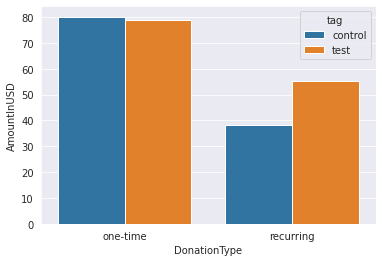

In [ ]:
sns.barplot(data=aov, x="DonationType", y="AmountInUSD",  hue="tag" )

## 3.5 CV - конверсия в донат

In [ ]:
ab_test1 = df['tag'].value_counts().to_frame(name='count')
ab_test2 = df_ab.query("EventType == 'charge'")
ab_test3 = ab_test2['tag'].value_counts().to_frame(name='count')
ctr = ab_test3['count']/ab_test1['count']*100
print('конверсия в донат для тестовой выборки = ', round(ctr[0],2), '%')
print('конверсия в донат для контрольной выборки = ', round(ctr[1],2), '%')
#ctr в донат (charge/checkoutView) для тестовой группы выросла 0,6%

конверсия в донат для тестовой выборки =  10.37 %
конверсия в донат для контрольной выборки =  9.71 %


## **4. Дополнительные метрики**

In [ ]:
df_donation = df_ab.groupby(['DonationType'], as_index=False)['AmountInUSD'].sum() 
df_donation 
#сумма донатов за период 
#412301 usd - за одноразовый донат
#7893 usd - регулярное пожертвование

,DonationType,AmountInUSD
0,one-time,412301.0
1,recurring,7893.0


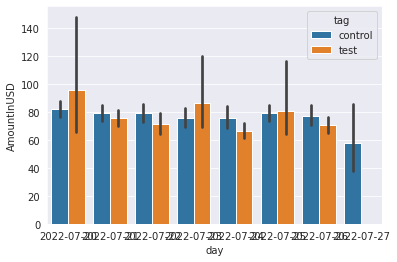

In [ ]:
sns.barplot(data=df_ab, x="day", y="AmountInUSD",  hue="tag" ) #распределение донатов по дням

In [ ]:
df_ab.groupby(['tag' ], as_index=False)['AmountInUSD'].count()
#общее колиечтво донатов выросло за тестовый период

,tag,AmountInUSD
0,control,2588
1,test,2776


In [ ]:
df_ab.groupby(['DonationType', 'tag'], as_index=False)['AmountInUSD'].count()
#общее колиечтво донатов выросло за тестовый период по типу доната

,DonationType,tag,AmountInUSD
0,one-time,control,2484
1,one-time,test,2705
2,recurring,control,104
3,recurring,test,71


## **5. Анализ A/B тестирования**

Для определения статзначимости нашего A/B тестирования возмем T-тест Стьюдента. Если в нашем эксперименте **p-value < 0.05**, тогда наща гипотеза верна и можно ее раскатывать в прод. 

За основную метрику берем Value -  сумма донатов за тестовый период (**сумма AmountInUSD**).

Но сразу посчитаем размер выборок, она должна быть примерно одинаковая

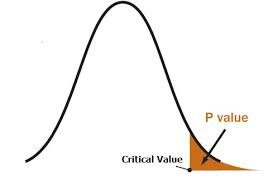


In [ ]:
df_users['tag'].value_counts() #размер выборки

test       23767
control    23615
Name: tag, dtype: int64

In [ ]:
df_users['tag'].value_counts(normalize = True) #нормализованый размер выборки

test       0.501604
control    0.498396
Name: tag, dtype: float64

Размер выборки примерно одинаковый. Продолжаем анализ данных A/B тестирования.

In [ ]:
ab_0 = df_users[df_users.tag == 'control'].query("EventType == 'charge'")
ab_1 = df_users[df_users.tag == 'test'].query("EventType == 'charge' ")
tt_test = stats.ttest_ind(ab_0.AmountInUSD, ab_1.AmountInUSD, equal_var=False)
print(tt_test)

Ttest_indResult(statistic=0.14934040446325264, pvalue=0.8812948572117484)


**pvalue=0.881**, что значит наши изменения не стат значимые.

Для уверенности проанализируем изменения в разрезе единоразовый донат / ежемесячный

In [ ]:
ab_0 = df_users_new[df_users_new.tag == 'control'].query("EventType == 'charge' and DonationType == 'one-time'")
ab_1 = df_users_new[df_users_new.tag == 'test'].query("EventType == 'charge' and DonationType == 'one-time'")
tt_test_onetime = stats.ttest_ind(ab_0.AmountInUSD, ab_1.AmountInUSD, equal_var=False)
print(tt_test_onetime)

Ttest_indResult(statistic=0.3906324577977725, pvalue=0.6960967972017519)


In [ ]:
ab_2 = df_users_new[df_users_new.tag == 'control'].query("EventType == 'charge' and DonationType == 'recurring'")
ab_3 = df_users_new[df_users_new.tag == 'test'].query("EventType == 'charge' and DonationType == 'recurring'")
tt_test_onetime = stats.ttest_ind(ab_2.AmountInUSD, ab_3.AmountInUSD, equal_var=False)
print(tt_test_onetime)

Ttest_indResult(statistic=-3.3773305377266367, pvalue=0.0010043488502111991)


In [ ]:
Для one-time доната p-value = 0.696, что больше 0.05. Значит изменения не статзначимые
Для recurring доанат p-value = 0.001, что меньше 0.05. Но сумма донатов для recurring в тестовой шруппе, значит нам явно не подходит.

# **Вывод**

Кажется, что после внесённых изменений сумма донатов выросла на 14148 usd, но в т-тестирование **p-value = 0.881, что больше 0.05.**

Это значит, что наши изменения стат НЕзначимы. И изменения НЕ рекомендуется раскатывать в прод.

Также есть выбросы. Например, Клиент с ClientID = 184432844, который заданатил 10000 usd и еще два доната по 5000 usd при среднем донате 80 usd.

Наше тестирование длилось всего 7 дней, есть смысл продлить наше тестирование и увеличить генеральную выборку. По окончанию тестирования провести расчеты еще раз.